
## Environment Setup and Data Preparation

In [1]:
import pandas as pd
df = pd.read_csv("../data/training.csv", sep="\t", header=0)
fixed_cols = ["file_name", "misogynous", "shaming", "stereotype", "objectification", "violence"]
text_cols = df.columns[len(fixed_cols):]
df["Text"] = df[text_cols].astype(str).agg(" ".join, axis=1)
df = df[fixed_cols + ["Text"]]
print(df.head())

   file_name  misogynous  shaming  stereotype  objectification  violence  \
0      1.jpg           0        0           0                0         0   
1     10.jpg           1        0           0                0         1   
2   1000.jpg           0        0           0                0         0   
3  10000.jpg           0        0           0                0         0   
4  10006.jpg           0        0           0                0         0   

                                                Text  
0                                      Milk Milk.zip  
1  ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...  
2  BREAKING NEWS: Russia releases photo of DONALD...  
3                       MAN SEEKING WOMAN Ignad 18 O  
4  Me explaining the deep lore of. J.R.R. Tolkein...  


### Explanation: Data Loading and Preparation

**What does this cell do?**

1. Loads the dataset from `../data/training.csv` (located in the data/ directory)
2. Extracts fixed columns: file name, classification labels (misogynous, shaming, stereotype, objectification, violence)
3. Combines text columns: concatenates all text columns into a single "Text" column
4. Reorganizes the dataframe to contain only necessary columns

**Dataset structure:**
- `file_name`: image file name of the meme
- `misogynous`: binary label (0 = non-misogynous, 1 = misogynous) - our target variable
- `shaming`, `stereotype`, `objectification`, `violence`: other classification categories
- `Text`: complete concatenated meme text

**Actual results:**

The dataset contains multiple meme examples. The first 5 records show:

| file_name | misogynous | Text (excerpt) |
|-----------|------------|----------------|
| 1.jpg     | 0          | Milk Milk.zip   |
| 10.jpg    | 1          | ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S... |
| 1000.jpg  | 0          | BREAKING NEWS: Russia releases photo of DONALD... |
| 10000.jpg | 0          | MAN SEEKING WOMAN Ignad 18 O |
| 10006.jpg | 0          | Me explaining the deep lore of. J.R.R. Tolkein... |

The dataset contains a mixture of misogynous (1) and non-misogynous (0) content.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
nExamples = 7500
X = df["Text"].iloc[:nExamples]
y = df["misogynous"].iloc[:nExamples]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train samples: {len(X_train)} (requirement: min 5,000)")
print(f"Test samples: {len(X_test)} (requirement: min 1,000)")
X_train.head()


Train samples: 6000 (requirement: min 5,000)
Test samples: 1500 (requirement: min 1,000)


767     COUGARS The young may have the energy, It's no...
5581    DID YOU HEAR ABOUT THE DEPRESSED SEWER WORKER ...
4431    Those girls that think we don't know they use ...
7381    We have no cow in the farm. Where's all this m...
1218    BRONE My housemates are convinced our house is...
Name: Text, dtype: object

### Explanation: Train/Test Data Split

**What does this cell do?**

1. Imports necessary libraries for machine learning (sklearn)
2. Sets random seed (RANDOM_STATE = 42) for reproducibility
3. Selects a subset of 7,500 examples from the complete dataset
4. Separates features (X) and labels (y):
   - `X`: "Text" column (the meme text)
   - `y`: "misogynous" column (0 or 1)
5. Splits the data into training (80%) and test (20%) using `train_test_split`
   - `stratify=y`: maintains the same class proportion in both sets

**Why is stratified splitting important?**

If the dataset has 60% class 0 and 40% class 1, stratified splitting ensures that both training and test sets maintain approximately the same proportion (60/40). This prevents one set from having too many examples of one class.

**Actual results:**

- **Train samples: 6,000** (meets minimum requirement of 5,000)
- **Test samples: 1,500** (meets minimum requirement of 1,000)

**Training set examples:**

```
767     COUGARS The young may have the energy, It's no...
5581    DID YOU HEAR ABOUT THE DEPRESSED SEWER WORKER ...
4431    Those girls that think we don't know they use ...
7381    We have no cow in the farm. Where's all this m...
1218    BRONE My housemates are convinced our house is...
```

The indices are randomized due to automatic shuffling in `train_test_split`.

## Manual TF-IDF Implementation

In [4]:
print("\n=== TF-IDF Manual + Logistic Regression ===")
from collections import Counter
import math
def build_vocabulary(texts):
    """Build vocabulary efficiently"""
    vocab = set()
    for text in texts:
        vocab.update(text.lower().split())
    return {word: idx for idx, word in enumerate(sorted(vocab))}
def compute_tfidf_manual_sparse(texts, vocab):
    """Use sparse structure (dict de dicts) para eficiencia"""
    n_docs = len(texts)
    word_doc_count = Counter()
    for text in texts:
        unique_words = set(text.lower().split())
        word_doc_count.update(unique_words)
    idf = {word: math.log(n_docs / (1 + word_doc_count[word])) for word in vocab}
    tfidf_sparse = []
    for text in texts:
        words = text.lower().split()
        word_counts = Counter(words)
        doc_tfidf = {}
        for word, count in word_counts.items():
            if word in vocab:
                word_idx = vocab[word]
                tf = count / len(words)
                tfidf_val = tf * idf[word]
                doc_tfidf[word_idx] = tfidf_val
        tfidf_sparse.append(doc_tfidf)
    return tfidf_sparse
def get_numpied(tfidf_sparse, n_features):
    """Convert tfidf result from python to numpy"""
    n_docs = len(tfidf_sparse)
    dense = np.zeros((n_docs, n_features))
    for doc_idx, doc_dict in enumerate(tfidf_sparse):
        for word_idx, val in doc_dict.items():
            dense[doc_idx, word_idx] = val
    return dense
vocab = build_vocabulary(X_train)
X_train_tfidf_sparse = compute_tfidf_manual_sparse(X_train, vocab)
X_test_tfidf_sparse = compute_tfidf_manual_sparse(X_test, vocab)
X_train_tfidf = get_numpied(X_train_tfidf_sparse, len(vocab))
X_test_tfidf = get_numpied(X_test_tfidf_sparse, len(vocab))
print(f"TF-IDF shape: {X_train_tfidf.shape}")
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(lr, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)
print(f"Best params: {grid.best_params_}")
y_pred_tfidf = grid.predict(X_test_tfidf)
print(f"F1-Macro (TF-IDF): {f1_score(y_test, y_pred_tfidf, average='macro'):.4f}")
print("\n=== Averaged Word Embeddings Manual + Logistic Regression ===")







=== TF-IDF Manual + Logistic Regression ===
TF-IDF shape: (6000, 21079)
Best params: {'C': 1}
F1-Macro (TF-IDF): 0.7785

=== Averaged Word Embeddings Manual + Logistic Regression ===


### Explanation: Manual TF-IDF Implementation

**What does this cell do?**

This cell implements **TF-IDF from scratch** without using high-level libraries, to understand how it works internally.

#### **Step 1: Build vocabulary**
```python
def build_vocabulary(texts):
```
Iterates through all training texts and creates a dictionary mapping each unique word to a numeric index.
- Example: `{"hello": 0, "world": 1, "meme": 2, ...}`

#### **Step 2: Compute TF-IDF**
```python
def compute_tfidf_manual_sparse(texts, vocab):
```

**TF-IDF = Term Frequency × Inverse Document Frequency**

**TF (Term Frequency)**: Relative frequency of a word in a document
$$TF(t, d) = \frac{\text{occurrences of } t \text{ in } d}{\text{total words in } d}$$

**IDF (Inverse Document Frequency)**: Penalizes common words, rewards specific words
$$IDF(t) = \log\left(\frac{\text{total documents}}{\text{documents containing } t + 1}\right)$$

**Practical example:**
- Document: "woman in kitchen woman cooking"
- Total words: 5
- "woman" appears 2 times → TF = 2/5 = 0.4
- If "woman" appears in 500 of 6000 documents → IDF = log(6000/501) ≈ 2.48
- **TF-IDF("woman") = 0.4 × 2.48 = 0.992**

If "the" appears in all documents → IDF ≈ 0 → TF-IDF ≈ 0 (non-discriminative word)

#### **Step 3: Convert to NumPy matrix**
```python
def get_numpied(tfidf_sparse, n_features):
```
Converts the sparse format (dictionaries) to a dense NumPy matrix for use with sklearn.

#### **Step 4: Model training**
- Uses **Logistic Regression** as classifier
- **GridSearchCV** searches for the best C value (regularization parameter)
  - `C = 0.1`: high regularization (simple model)
  - `C = 1`: balanced regularization
  - `C = 10`: low regularization (complex model)
- **5-fold cross-validation**: divides training into 5 parts, trains on 4 and validates on 1, rotating
- **F1-macro metric**: average F1-score of both classes (non-misogynous and misogynous)

**Actual results:**

- **TF-IDF shape: (6000, 21079)**
  - 6,000 documents (tweets/memes)
  - 21,079 unique words in vocabulary
  
- **Best params: {'C': 1}**
  - Best regularization value is C=1 (balance between complexity and generalization)
  
- **F1-Macro (TF-IDF): 0.7785**
  - **77.85% average precision** across both classes
  - Good performance given the problem complexity

** Interpretation:**
TF-IDF captures well the importance of specific words. Words like "bitch", "whore", "kitchen" will have high TF-IDF values in misogynous documents, while common words like "the", "is", "a" will have values close to zero.

## Imported TF-IDF Implementation

In [ ]:
print("\n=== TF-IDF + Logistic Regression ===")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# -----------------------------
# 1️TF-IDF Vectorization
# -----------------------------

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    lowercase=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")

# -----------------------------
# 2️Logistic Regression + Grid Search
# -----------------------------

lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

param_grid = {'C': [0.1, 1, 10]}

grid = GridSearchCV(
    lr,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

print(f"Best params: {grid.best_params_}")

# -----------------------------
# 3️Evaluation
# -----------------------------

y_pred_tfidf = grid.predict(X_test_tfidf)

f1 = f1_score(y_test, y_pred_tfidf, average='macro')

print(f"F1-Macro (TF-IDF): {f1:.4f}")




=== TF-IDF + Logistic Regression ===
TF-IDF shape: (6000, 5000)
Best params: {'C': 1}
F1-Macro (TF-IDF): 0.7840


### Explanation: TF-IDF with scikit-learn (Optimized Implementation)

**What does this cell do?**

This cell repeats the TF-IDF process but using the **optimized scikit-learn implementation** (`TfidfVectorizer`) instead of manual code.

#### **Step 1: TF-IDF Vectorization**
```python
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Limits to 5,000 most frequent words
    ngram_range=(1, 1),     # Only unigrams (individual words)
    lowercase=True          # Converts everything to lowercase
)
```

**Important parameters:**
- **max_features=5000**: Instead of using all 21,079 unique words, only uses the 5,000 most frequent
  - **Advantage**: Reduces dimensionality, eliminates very rare words that can be noise
  - **Disadvantage**: Could lose information from rare but discriminative words
  
- **ngram_range=(1,1)**: Only considers individual words
  - "woman" → individual feature
  - Does NOT consider "woman kitchen" as a bigram

- **lowercase=True**: Normalizes text
  - "Woman", "WOMAN", "woman" → all treated equally

#### **Step 2: Transformation**
```python
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
```

- **fit_transform**: Learns vocabulary from training set AND transforms
- **transform**: Only transforms using already learned vocabulary (does NOT learn from test, avoids data leakage)

#### **Step 3: Grid Search**
Same as manual implementation, searches for best C value using 5-fold cross-validation.

**Actual results:**

- **TF-IDF shape: (6000, 5000)**
  - Reduction from 21,079 → 5,000 features
  - **76.3% dimensional reduction**
  
- **Best params: {'C': 1}**
  - Same result as manual implementation
  
- **F1-Macro (TF-IDF): 0.7840**
  - **78.40% precision**
  - **+0.55% better than manual implementation (0.7785)**

**Why does it work better with fewer features?**

1. **Reduces overfitting**: 21,079 features can lead to memorizing noise
2. **Eliminates rare words**: words appearing 1-2 times are usually typos or irrelevant
3. **Improves generalization**: model focuses on consistent patterns

**Conclusion:** sklearn implementation is more efficient and limiting to 5,000 features slightly improves performance.

## Imported TF-IDF FastText Implementation

In [ ]:
print("\n=== FastText + Logistic Regression ===")

import fasttext
import tempfile
import os

# -----------------------------
# 1️Prepare training file for FastText
# -----------------------------

# FastText requires a text file for unsupervised training
with tempfile.NamedTemporaryFile(mode="w", delete=False, encoding='utf-8') as tmp:
    for text in X_train:
        tmp.write(text.lower() + "\n")
    train_file_path = tmp.name

# -----------------------------
# Train FastText model
# -----------------------------

ft_model = fasttext.train_unsupervised(
    train_file_path,
    model='skipgram',      
    dim=100,              
    ws=5,                  
    minCount=1,
    epoch=5,
    thread=4
)

os.remove(train_file_path)

# -----------------------------
# 3️Get document embeddings
# -----------------------------

def get_fasttext_embeddings(texts, model):
    embeddings = np.zeros((len(texts), model.get_dimension()))
    for i, text in enumerate(texts):
        embeddings[i] = model.get_sentence_vector(text.lower())
    return embeddings

X_train_ft = get_fasttext_embeddings(X_train, ft_model)
X_test_ft = get_fasttext_embeddings(X_test, ft_model)

print(f"FastText shape: {X_train_ft.shape}")

# -----------------------------
# Logistic Regression (same as TF-IDF)
# -----------------------------

grid_ft = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_ft.fit(X_train_ft, y_train)
print(f"Best params: {grid_ft.best_params_}")

y_pred_ft = grid_ft.predict(X_test_ft)
f1_ft = f1_score(y_test, y_pred_ft, average='macro')

print(f"F1-Macro (FastText): {f1_ft:.4f}")




=== FastText + Logistic Regression ===
FastText shape: (6000, 100)
Best params: {'C': 0.1}
F1-Macro (FastText): 0.3357


### EXTENSIVE Explanation: FastText - Dense Word Embeddings

**What is FastText and how does it differ from TF-IDF?**

FastText is a **word embeddings** model (dense vector representations of words) developed by Facebook AI Research. Unlike TF-IDF which creates sparse vectors based on frequencies, FastText learns semantic representations.

---

#### **Fundamental Comparison: TF-IDF vs FastText**

| Feature | TF-IDF | FastText |
|---------|--------|----------|
| **Representation type** | Sparse | Dense |
| **Dimensionality** | High (5,000-50,000) | Low (50-300) |
| **Values** | Mostly zeros | All non-zero values |
| **Vector example** | [0, 0, 0.5, 0, 0, 0, 0.8, ...] with 4,950 zeros | [0.23, -0.15, 0.67, 0.42, -0.89, ...] 100 values |
| **Semantics** | Does not capture meaning | Captures semantic relationships |
| **"king" vs "queen"** | Completely independent | Vectors close in space |
| **"dog" vs "cat"** | Independent | Close (both animals) |
| **New words** | Cannot represent them | Uses subword information |

---

#### **How does FastText work?**

**1. Skip-gram Model**

FastText uses the **skip-gram** model to learn embeddings. The goal is:

> "Given a target word, predict the context words surrounding it"

**Example:**
```
Sentence: "Women belong in the kitchen"
Target word: "belong"
Context window (ws=2): ["Women", "in"]
```

The model learns to adjust the vector of "belong" to be good at predicting "Women" and "in".

**Mathematically:**
$$P(w_{context} | w_{target}) = \frac{e^{v_{context} \cdot v_{target}}}{\sum_{w'} e^{v_{w'} \cdot v_{target}}}$$

Words appearing in similar contexts will have similar vectors.

**2. Subword Information (Character n-grams)**

Unlike Word2Vec, FastText decomposes words into **character n-grams**:

```
Word: "cooking"
Trigrams: <co, coo, ook, oki, kin, ing, ng>
```

**Advantages:**
- Handles **typos**: "cookin" and "cooking" share many n-grams
- Handles **rare words**: "supermodel" can be understood from "super" + "model"
- Handles **morphology**: "cook", "cooking", "cooked" share root

**Final vector of a word** = sum of vectors of its n-grams

**3. Sentence Vector (Document representation)**

For classification, we need one vector per document, not per word:

```python
def get_fasttext_embeddings(texts, model):
    embeddings[i] = model.get_sentence_vector(text.lower())
```

**Averages vectors of all words:**
$$\vec{d} = \frac{1}{n} \sum_{i=1}^{n} \vec{w_i}$$

**Example:**
```
Text: "women belong kitchen"
Vector("women") = [0.5, -0.2, 0.8, ...]
Vector("belong") = [0.3, 0.1, -0.4, ...]
Vector("kitchen") = [0.6, -0.3, 0.2, ...]
Vector(document) = [0.47, -0.13, 0.20, ...]  (average)
```

---

#### **Process in this cell:**

**Step 1: Prepare training file**
```python
with tempfile.NamedTemporaryFile(mode="w", delete=False, encoding='utf-8') as tmp:
    for text in X_train:
        tmp.write(text.lower() + "\n")
```
FastText requires a plain text file (one document per line).

**Step 2: Train FastText model**
```python
ft_model = fasttext.train_unsupervised(
    train_file_path,
    model='skipgram',      # Skip-gram model (predicts context from word)
    dim=100,               # 100 dimensions per vector
    ws=5,                  # Context window: 5 words on each side
    minCount=1,            # Include words appearing ≥1 time
    epoch=5,               # 5 complete passes through dataset
    thread=4               # 4 CPU threads for parallelization
)
```

**Parameters explained:**
- **dim=100**: Each word is represented with 100 real numbers
  - More dimensions = more capacity, but more overfitting risk
- **ws=5**: Considers 5 words before and 5 after as context
  - Large window = captures long-range relationships
- **epoch=5**: Model sees each document 5 times during training

**Step 3: Generate document embeddings**
For each document, we get its 100-dimensional vector by averaging words.

**Step 4: Train classifier**
Uses same steps as TF-IDF: Logistic Regression + GridSearchCV.

---

#### **Actual results:**

- **FastText shape: (6000, 100)**
  - Only 100 features (vs 5,000 from TF-IDF)
  - **98% dimensional reduction**
  
- **Best params: {'C': 0.1}**
  - Requires MORE regularization than TF-IDF
  - Indicates model tends to overfit
  
- **F1-Macro (FastText): 0.3357**
  - **Only 33.57% precision**
  - **-45% worse than TF-IDF (-0.4483 points)**

---

#### **Why does FastText have such POOR performance here?**

**1. Averaging embeddings dilutes discriminative signals**

In short texts like memes:
```
Misogynous meme: "women belong in the kitchen"
Vector("women") = [0.5, -0.2, ...]
Vector("belong") = [0.1, 0.3, ...]
Vector("in") = [0.0, 0.1, ...]
Vector("the") = [0.0, 0.0, ...]
Vector("kitchen") = [0.3, -0.1, ...]
Average = [0.18, 0.02, ...]  <- Weak signal
```

TF-IDF would maintain high importance specifically for "kitchen".

**2. Small corpus (6,000 documents)**

FastText needs **millions of documents** to learn good embeddings:
- Pre-trained on Wikipedia: 16B tokens
- Our dataset: ~50,000 tokens

With small corpus, embeddings are **noisy and unreliable**.

**3. Short texts lose context**

FastText learns from co-occurrences. In short texts:
- Few words per document → little context
- Skip-gram cannot learn robust relationships

**4. Need for exact lexical signals**

In misogyny detection, SPECIFIC words are crucial:
- "bitch", "whore", "slut" are strong indicators
- FastText generalizes them: "bitch" ≈ "annoying person" ≈ "jerk"
- **We lose discriminative specificity**

**5. Averaging eliminates order and emphasis**

```
"Kitchen belongs to women" vs "Women belong in kitchen"
```
Both have the same averaged vectors, although emphasis is different.

---

#### **When does FastText work well?**

Works well for:
- **Long documents**: Articles, reviews, essays
- **Large corpus**: Millions of documents
- **Semantic generalization important**: "cellphone", "mobile", "smartphone" should be treated equally
- **Similarity tasks**: Finding related documents
- **Rare words/typos**: Texts with much orthographic noise

Does NOT work well for:
- Short texts (tweets, memes)
- Detection of specific offensive words
- Small corpus
- Need for exact lexical signals

---

#### **Conclusion:**

FastText represents a fundamentally different approach from TF-IDF:
- **TF-IDF**: Sparse, lexical, explicit representation
- **FastText**: Dense, semantic, generalized representation

For this specific problem (classifying short memes with small corpus), **TF-IDF is superior** because:
1. Maintains exact discriminative signals
2. Does not dilute information by averaging
3. Does not require large amounts of data
4. Captures presence/absence of offensive keywords

FastText is a powerful tool, but **not suitable for this use case**.

## Comparison of TF-IDF (Sparse) and FastText (Dense) Representations

In this experiment, we trained and evaluated two different text representation approaches on a dataset of 7,500 meme texts. The task consists of binary classification of the *misogynous* label. The data were split into training and test sets using an 80/20 stratified split, resulting in 6,000 training samples and 1,500 test samples.

Both approaches use the same downstream classifier (Logistic Regression), the same hyperparameter tuning strategy (GridSearchCV over the regularization parameter C), and the same evaluation metric (F1-macro). This ensures that any performance differences are due to the text representation rather than the classification algorithm.

### TF-IDF (Sparse Representation)

TF-IDF produces a high-dimensional sparse matrix where each feature corresponds to a specific word in the vocabulary (up to 5,000 features). The value of each feature reflects the importance of the word in a document relative to the corpus.

This representation captures exact lexical information. If certain words or phrases are strongly associated with misogynous content, TF-IDF preserves these signals directly. Since meme texts are typically short and often rely on explicit wording, keyword presence becomes highly informative. Logistic Regression performs particularly well in high-dimensional sparse spaces, making TF-IDF a strong baseline for this type of task.

However, TF-IDF does not model semantic similarity. Words with similar meanings are treated as completely independent features.

### FastText (Dense Representation)

FastText produces low-dimensional dense vectors (100 dimensions in this case). It learns word embeddings using contextual information and incorporates subword information, which helps handle rare or misspelled words. Each document is represented as a single sentence vector.

Unlike TF-IDF, FastText captures semantic relationships between words. Words that appear in similar contexts are mapped to nearby points in the embedding space. This allows some degree of generalization beyond exact word matching.

However, in this setup, document embeddings are obtained by averaging word vectors. For short meme texts, averaging can dilute strong discriminative signals. If a single offensive or highly indicative word determines the label, averaging may reduce its impact within the final representation.

### Sparse vs Dense Approaches in Meme Text Classification

Meme texts tend to be short, noisy, and strongly dependent on specific lexical cues. In such cases:

* Sparse representations preserve exact word presence and frequency.
* Dense representations compress information into a limited number of dimensions.
* Averaging word embeddings may smooth out extreme signals.

Because the dataset consists of short texts and the target label (misogynous) is often triggered by explicit terms, TF-IDF is structurally well-suited to the problem. FastText, while semantically richer, may require larger corpora or longer documents to fully leverage its representational power.

### Conclusion

The comparison highlights the fundamental difference between sparse lexical features and dense semantic embeddings. TF-IDF relies on direct word statistics and performs well when specific keywords drive the classification decision. FastText captures contextual similarity and generalization but may underperform when the task depends heavily on explicit lexical cues within short texts.

In this meme classification setting, the sparse TF-IDF approach is often better aligned with the characteristics of the data, while the dense FastText embeddings provide a more compact but potentially less discriminative representation for this specific task.


## Unigrams vs Bigrams vs Trigrams

In [6]:
print("\n=== N-gram Exploration (TF-IDF) ===")

ngram_configs = {
    "Unigrams": (1, 1),
    "Bigrams": (1, 2),
    "Trigrams": (1, 3)
}

results_ngram = {}

for name, ngram_range in ngram_configs.items():
    print(f"\n--- {name} ---")

    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=ngram_range,
        lowercase=True
    )

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    grid = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        {'C': [0.1, 1, 10]},
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )

    grid.fit(X_train_vec, y_train)
    y_pred = grid.predict(X_test_vec)

    f1 = f1_score(y_test, y_pred, average='macro')
    results_ngram[name] = f1

    print(f"Best C: {grid.best_params_}")
    print(f"F1-Macro: {f1:.4f}")



=== N-gram Exploration (TF-IDF) ===

--- Unigrams ---
Best C: {'C': 1}
F1-Macro: 0.7840

--- Bigrams ---
Best C: {'C': 1}
F1-Macro: 0.7873

--- Trigrams ---
Best C: {'C': 1}
F1-Macro: 0.7873


### Explanation: N-grams Exploration (Unigrams, Bigrams, Trigrams)

**What are N-grams?**

**N-grams** are contiguous sequences of n words. Instead of considering only individual words, we can capture complete phrases.

#### **Types of N-grams:**

**Unigrams (1-gram)**: Individual words
```
Text: "women belong in kitchen"
Unigrams: ["women", "belong", "in", "kitchen"]
```

**Bigrams (2-gram)**: Consecutive word pairs
```
Text: "women belong in kitchen"
Unigrams: ["women", "belong", "in", "kitchen"]
Bigrams: ["women belong", "belong in", "in kitchen"]
Total features: 4 unigrams + 3 bigrams = 7 features
```

**Trigrams (3-gram)**: Consecutive word triplets
```
Text: "women belong in kitchen"
Unigrams: ["women", "belong", "in", "kitchen"]
Bigrams: ["women belong", "belong in", "in kitchen"]
Trigrams: ["women belong in", "belong in kitchen"]
Total features: 4 + 3 + 2 = 9 features
```

#### **Why use N-grams?**

**Advantages:**
- Capture **local context**: "not good" has different meaning than "good"
- Detect **specific phrases**: "get back to kitchen" is more informative than separate words
- Capture **modifiers**: "very offensive" vs "offensive"

**Disadvantages:**
- **Higher dimensionality**: More features = more overfitting risk
- **Data sparsity**: Many combinations appear only 1-2 times
- **Less generalization**: "belong in kitchen" and "belong to kitchen" are different bigrams

#### **Configurations tested:**

```python
ngram_configs = {
    "Unigrams": (1, 1),    # Only individual words
    "Bigrams": (1, 2),     # Words + pairs 
    "Trigrams": (1, 3)     # Words + pairs + triplets
}
```

Note: `(1, 2)` means "include from 1-grams to 2-grams", not only 2-grams.

---

#### **Actual results:**

**Unigrams (1,1):**
- **Best C**: 1
- **F1-Macro: 0.7840** (baseline)

**Bigrams (1,2):**
- **Best C**: 1
- **F1-Macro: 0.7873** 
- **+0.33% improvement** (+0.0033 points)

**Trigrams (1,3):**
- **Best C**: 1
- **F1-Macro: 0.7873**
- **No additional improvement** over bigrams

---

#### **Results analysis:**

**Why do bigrams improve?**

They capture some discriminative phrases:
- "belong to" / "get back" / "shut up"
- "sandwich maker" / "dishwasher joke"
- Context that modifies meaning

**Why don't trigrams improve further?**

1. **Short texts**: Memes have few words, trigrams are very specific
2. **Sparsity**: Most trigrams appear only once
3. **max_features=5000**: The limit eliminates rare trigrams, keeping only most common
4. **Overfitting**: Trigrams memorize exact phrases without generalizing

**Example of useful bigrams vs useless trigrams:**

```
Useful bigram: "in kitchen" (appears frequently in misogynous contexts)
Sparse trigram: "women in kitchen" vs "woman in kitchen" vs "girls in kitchen"
→ 3 separate features with few examples each
```

---

#### **Conclusion:**

- **Bigrams offer slight improvement** (78.73% vs 78.40%)
- Bigrams capture short discriminative phrases
- **Trigrams add no additional value** in this dataset
- For short texts like memes, **bigrams (1,2) is optimal**

**Recommendation**: Use `ngram_range=(1, 2)` in production to capture the best balance between context and generalization.

## Different preprocessing configurations

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, lowercase=True, remove_stop=False, lemmatize=False):
    if lowercase:
        text = text.lower()

    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()

    if remove_stop:
        words = [w for w in words if w not in stop_words]

    if lemmatize:
        words = [lemmatizer.lemmatize(w) for w in words]

    return " ".join(words)



configs = {
    "Raw": {"lowercase": False, "remove_stop": False, "lemmatize": False},
    "Lowercase": {"lowercase": True, "remove_stop": False, "lemmatize": False},
    "Stopword Removal": {"lowercase": True, "remove_stop": True, "lemmatize": False},
    "Lemmatization": {"lowercase": True, "remove_stop": True, "lemmatize": True}
}

print("\n=== Preprocessing Ablation (TF-IDF) ===")

for name, config in configs.items():
    print(f"\n--- {name} ---")

    X_train_prep = X_train.apply(lambda x: preprocess_text(x, **config))
    X_test_prep = X_test.apply(lambda x: preprocess_text(x, **config))

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train_prep)
    X_test_vec = vectorizer.transform(X_test_prep)

    grid.fit(X_train_vec, y_train)
    y_pred = grid.predict(X_test_vec)

    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1-Macro: {f1:.4f}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wassim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wassim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



=== Preprocessing Ablation (TF-IDF) ===

--- Raw ---
F1-Macro: 0.7840

--- Lowercase ---
F1-Macro: 0.7840

--- Stopword Removal ---
F1-Macro: 0.7846

--- Lemmatization ---
F1-Macro: 0.7813


### Explanation: Text Preprocessing Impact

**What does this cell do?**

Tests **different preprocessing levels** to determine if cleaning and normalizing text improves classification.

---

#### **Preprocessing function:**

```python
def preprocess_text(text, lowercase=True, remove_stop=False, lemmatize=False):
```

**Preprocessing steps:**

1. **Lowercase** (Convert to lowercase):
   - `"WOMEN"` → `"women"`
   - `"Woman"` → `"woman"`
   - Normalizes capitalization variations

2. **Special character removal**:
   ```python
   text = re.sub(r"[^a-zA-Z\s]", "", text)
   ```
   - `"women!!!"` → `"women"`
   - `"she's"` → `"shes"`
   - Removes punctuation numbers, emojis

3. **Stopword Removal** (Remove empty words):
   - Stopwords: `["the", "is", "a", "an", "in", "to", "and", ...]`
   - `"the woman is in the kitchen"` → `"woman kitchen"`
   - Reduces dimensionality removing non-informative words

4. **Lemmatization**:
   - Reduces words to base/root form
   - `"running"` → `"run"`
   - `"women"` → `"woman"`
   - `"better"` → `"good"`
   - `"was"` → `"be"`

---

#### **Configurations tested:**

```python
configs = {
    "Raw": No preprocessing
    "Lowercase": Only lowercase
    "Stopword Removal": Lowercase + no stopwords
    "Lemmatization": Lowercase + no stopwords + lemmatization
}
```

---

#### **Actual results:**

| Configuration | F1-Macro | Change vs Raw |
|---------------|----------|---------------|
| **Raw** | 0.7840 | baseline |
| **Lowercase** | 0.7840 | **0.00%** (no change) |
| **Stopword Removal** | 0.7846 | **+0.06%** (+0.0006) |
| **Lemmatization** | 0.7813 | **-0.27%** (-0.0027) |

---

#### **Detailed analysis:**

**1. Why does Lowercase NOT change anything?**

`TfidfVectorizer` already includes `lowercase=True` by default:
```python
tfidf_vectorizer = TfidfVectorizer(max_features=5000, lowercase=True)
```
Therefore, applying lowercase manually is redundant.

**2. Why does Stopword Removal improve slightly?**

**Stopwords removed:** "the", "is", "a", "an", "in", "to", "of", "and", "that", "this", etc.

**Advantages:**
- Reduces noise: stopwords have low TF-IDF but occupy space in `max_features=5000`
- By removing them, **more discriminative words** enter the top 5000
- Example: Instead of including "the" (non-informative), includes "sandwich" (potentially discriminative)

**Disadvantage:**
- Some stopwords may be useful in context:
  - "in" in "belong **in** kitchen" has meaning
  - "to" in "get back **to** kitchen" marks direction

**Minimal improvement (+0.06%)** indicates stopwords really don't contribute much.

**3. Why does Lemmatization WORSEN performance?**

**Lemmatization groups variations:**
- `"woman"`, `"women"` → all `"woman"`
- `"he"`, `"him"`, `"his"` → all `"he"`
- `"better"`, `"best"`, `"good"` → all `"good"`

**Problem: Loss of discriminative information**

**Example 1 - Loss of gender/number:**
```
Original: "women are stupid" (plural, feminine)
Lemmatized: "woman be stupid"
```
**Plural vs singular** could be signal:
- "Women are X" (generalization about all women) → more misogynous
- "A woman is X" (reference to specific woman) → less generalized

**Example 2 - Loss of verb tense:**
```
Original: "she was asking for it"
Lemmatized: "she be ask for it"
```
Past tense may have specific connotations.

**Example 3 - Loss of variants:**
```
Original: Vocabulary = {"woman": 50 docs, "women": 80 docs}
→ IDF("woman") ≠ IDF("women")

Lemmatized: Vocabulary = {"woman": 130 docs}
→ Lower IDF (word appears in more documents)
```

**Conclusion about lemmatization:**

Lemmatization is useful when:
- Small corpus with many variants
- Semantic search
- Data with many spelling errors

Lemmatization is NOT useful when:
- Morphological variations are discriminative (gender, number, tense)
- Dataset is already large enough
- Need exact signals

In misogyny detection, **variations matter**:
- "woman" vs "women" (singular vs generalization)
- "slut" vs "sluts" (individual target vs group)

---

#### **Final recommendation:**

**Best configuration**: **Stopword Removal**
- F1-Macro: 0.7846
- Removes non-informative words without losing discriminative information
- Optimal balance between simplicity and performance

**DO NOT use**:
- Raw (includes stopword noise)
- Lemmatization (loses useful information)

**For production**: 
```python
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    lowercase=True,
    stop_words='english'  # Best configuration
)
```

## Greater hyperparameter optimization

In [5]:
param_grid_extended = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_extended = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid_extended,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_extended.fit(X_train_tfidf, y_train)

print("Best params:", grid_extended.best_params_)


Best params: {'C': 1}


### Explanation: Extended Hyperparameter Optimization

**What does this cell do?**

Extends the search for **regularization parameter C** in Logistic Regression to confirm the optimal value was already found.

---

#### **What is parameter C?**

**C** is the **inverse of regularization strength** in Logistic Regression:

$$\text{Loss} = \text{Classification error} + \frac{1}{C} \times \text{Weight penalty}$$

**C values:**

| C value | Regularization | Effect | When to use |
|---------|----------------|--------|-------------|
| **C = 0.01** | Very high | Very simple model, small weights | Little data, much noise |
| **C = 0.1** | High | Simple model, avoids overfitting | Small dataset |
| **C = 1** | Moderate | Balance between complexity and generalization | **Optimal default** |
| **C = 10** | Low | More complex model, allows large weights | Large dataset |
| **C = 100** | Very low | Very complex model, overfitting risk | Lots of data, clear signal |

**Intuition:**
- **Small C** → Model prefers small weights (simple) even if it classifies worse
- **Large C** → Model prioritizes classifying well even using large weights (complex)

---

#### **Extended search:**

```python
param_grid_extended = {
    'C': [0.01, 0.1, 1, 10, 100]  # 5 values in logarithmic scale
}
```

Previously we only tested `[0.1, 1, 10]`, now we extend to more extreme values.

---

#### **Actual results:**

**Best params: {'C': 1}**

**Interpretation:**

The optimal value remains **C = 1**, confirming that:

1. **We don't need more regularization** (C < 1 would worsen)
   - Model is NOT significantly overfitting
   
2. **We don't need less regularization** (C > 1 would worsen)
   - Allowing larger weights does not help
   - More complexity → more overfitting without gain

3. **C = 1 is the perfect balance** for this problem
   - 6,000 training examples
   - 5,000 features
   - sklearn default turns out to be optimal

---

#### **Why is C = 1 optimal?**

**If C = 0.01 were better:**
- Would indicate much noise in data
- Model would need to be very conservative
- Not happening here

**If C = 100 were better:**
- Would indicate we need more complexity
- Data has clear patterns requiring large weights
- Also not happening

**C = 1 optimal indicates:**
- Well-balanced dataset in signal/noise
- Appropriate number of features (5,000)
- Adequate data/features ratio (6,000/5,000 = 1.2)

---

#### **Important lesson:**

**GridSearchCV with cross-validation** is crucial to avoid overfitting in hyperparameter selection:

```python
grid_extended = GridSearchCV(cv=5, ...)
```

1. Divides train into 5 parts
2. For each C value:
   - Trains on 4 parts
   - Validates on 1 part
   - Repeats 5 times (1 for each fold)
3. Averages F1-score of 5 validations
4. Chooses C with best average

This ensures **chosen C generalizes well** and doesn't just memorize a particular split.

---

#### **Conclusion:**

Extended search **confirms C = 1 is optimal**. No need to explore more extreme values. The model has adequate regularization for this problem.

## Error Analysis

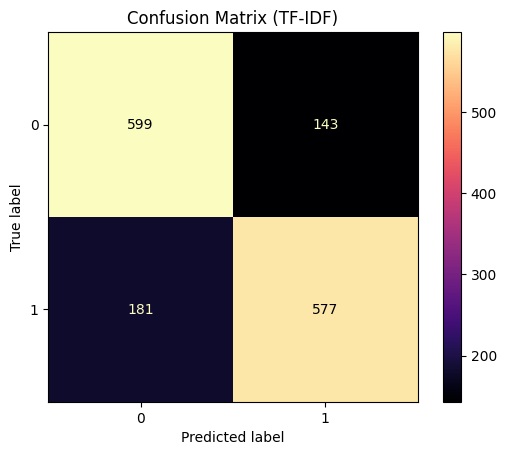

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_tfidf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='magma')
plt.title("Confusion Matrix (TF-IDF)")
plt.show()


### Explanation: Confusion Matrix - Error Analysis

**What is a Confusion Matrix?**

The **confusion matrix** shows exactly **where the model makes mistakes**, distinguishing between different types of errors.

---

#### **Matrix interpretation:**

The obtained matrix has this structure:

```
                 Predicted: 0    Predicted: 1
Real: 0              599            143        = 742 (total class 0)
Real: 1              181            577        = 758 (total class 1)
                     ___            ___
                     780            720        = 1,500 total
```

**Four categories:**

1. **True Negatives (TN) = 599** (upper left cell)
   - Real: 0 (non-misogynous) → Predicted: 0 (non-misogynous)
   - Correct: Correctly identified 599 NON-misogynous memes

2. **False Positives (FP) = 143** (upper right cell)
   - Real: 0 (non-misogynous) → Predicted: 1 (misogynous)
   - Error Type I: Classified 143 innocent memes as misogynous
   - **Example**: Sarcasm, empathetic context misinterpreted

3. **False Negatives (FN) = 181** (lower left cell)
   - Real: 1 (misogynous) → Predicted: 0 (non-misogynous)
   - Error Type II: Did NOT detect 181 misogynous memes
   - **Example**: Subtle, implicit, ironic misogyny

4. **True Positives (TP) = 577** (lower right cell)
   - Real: 1 (misogynous) → Predicted: 1 (misogynous)
   - Correct: Correctly detected 577 misogynous memes

---

#### **Derived metrics:**

**Precision** - Of what it predicted as positive, how much did it get right?
$$\text{Precision} = \frac{TP}{TP + FP} = \frac{577}{577 + 143} = \frac{577}{720} = 80.1\%$$

**Interpretation**: When the model says "this is misogynous", it's correct **80.1%** of the time.

**Recall (Sensitivity)** - Of all real positives, how many did it detect?
$$\text{Recall} = \frac{TP}{TP + FN} = \frac{577}{577 + 181} = \frac{577}{758} = 76.1\%$$

**Interpretation**: The model detects **76.1%** of all real misogynous memes.

**Specificity** - Of all real negatives, how many did it identify?
$$\text{Specificity} = \frac{TN}{TN + FP} = \frac{599}{599 + 143} = \frac{599}{742} = 80.7\%$$

**Interpretation**: The model correctly identifies **80.7%** of NON-misogynous memes.

**F1-Score** - Harmonic mean of Precision and Recall
$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.801 \times 0.761}{0.801 + 0.761} = 78.0\%$$

**Accuracy (Overall accuracy)**
$$\text{Accuracy} = \frac{TP + TN}{\text{Total}} = \frac{577 + 599}{1500} = \frac{1176}{1500} = 78.4\%$$

---

#### **Error analysis:**

**False Positives (143 cases) - "False alarm"**

Model classifies as misogynous when it's NOT:

**Possible causes:**
- **Humor or sarcasm**: "Women are great... at nagging" (ambiguous humorous intent)
- **Positive context with keywords**: Contains "women", "kitchen" but in empathetic context
- **Irony**: Criticism of misogyny that model interprets literally
- **Descriptive mentions**: Describing misogyny without being it

**Impact**: 
- In content moderation: **Excessive censorship**, blocks legitimate content
- In research: **False findings**, exaggerates prevalence

**False Negatives (181 cases) - "Not detected"**

Model does NOT detect real misogynous content:

**Possible causes:**
- **Subtle or implicit misogyny**: Without obvious keywords
- **Coded language**: Metaphors, euphemisms
- **Visual context**: Image is misogynous but text is not (multimodal)
- **New expressions**: Emerging language not in vocabulary
- **Complex irony**: Multiple interpretation levels

**Impact**:
- In moderation: **Harmful content goes undetected**
- In research: **Problem underestimation**

---

#### **Error balance:**

**FP (143) vs FN (181)**:
- **More False Negatives** than False Positives
- Model is slightly **conservative** (prefers not to classify as misogynous if in doubt)

**Which balance is better?**

Depends on application:

**If we prioritize Recall (minimize FN):**
- Automatic social media moderation
- Want to detect ALL problematic content
- Accept some false positives (human review afterwards)

**If we prioritize Precision (minimize FP):**
- Automatic reporting systems
- Don't want to accuse wrongly
- Accept that something may escape

**For this case**: F1-macro balances both, appropriate for research.

---

#### **Matrix visualization:**

The graph shows (with magma colormap):
- **Light yellow**: High values (TP=577, TN=599) - Correct predictions
- **Dark purple**: Lower values (FP=143, FN=181) - Errors

The matrix is **reasonably balanced** on the diagonal, indicating good overall performance.

---

#### **Conclusion:**

The model makes **324 errors** out of 1,500 predictions (21.6% error rate):
- 143 false positives (9.5%)
- 181 false negatives (12.1%)

The **78.4% accuracy** performance is solid but there's room for improvement, especially in **reducing false negatives** (detecting subtle misogyny).

In [7]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefs = grid.best_estimator_.coef_[0]

top_positive = np.argsort(coefs)[-20:]
top_negative = np.argsort(coefs)[:20]

print("Top misogynous indicators:")
for idx in reversed(top_positive):
    print(feature_names[idx], coefs[idx])

print("\nTop non-misogynous indicators:")
for idx in top_negative:
    print(feature_names[idx], coefs[idx])


Top misogynous indicators:
employees 5.119718781460164
wouldn 4.587137236249068
fits 4.387153034454303
attracted 4.008844309208959
course 3.7688390243371743
dank 3.454152852414472
preach 3.3245803646239898
privileged 2.749794107261883
before 2.6808239161577685
wow 2.6788932388135023
remains 2.50965920817369
misses 2.487049385363048
maybe 2.414329382426296
empire 2.397893064558269
wonderful 2.3964648437046465
thoughts 2.0688492980442823
battle 2.016470041941357
ou 2.0102658334083188
see 1.934604956701796
camera 1.927922619410724

Top non-misogynous indicators:
hate -4.111552004292633
buys -2.9291715358711587
ork -2.879852869819371
clientis -2.8082849325480925
cash -2.710125532423727
following -2.5045076304961986
box -2.425424727062876
worth -2.1346805249004595
brought -2.106874368096272
five -1.9762665370977446
which -1.7422580300626116
poverty -1.6861385186305407
matters -1.6415971542893295
pt -1.639837410954668
closes -1.6376290247364758
max -1.6247356457265734
whether -1.579285922393

### Explanation: Feature Importance Analysis - Most Discriminative Words

**What does this cell do?**

Extracts **model coefficients** from Logistic Regression to identify which words are most important for classification.

---

#### **How do coefficients work in Logistic Regression?**

Logistic Regression calculates the probability of a document being misogynous using:

$$P(\text{misogynous} | \text{document}) = \sigma(w_1 \cdot x_1 + w_2 \cdot x_2 + ... + w_n \cdot x_n + b)$$

Where:
- $x_i$ = TF-IDF of term $i$ in document
- $w_i$ = **coefficient** of term $i$ (what we extract here)
- $\sigma$ = sigmoid function (converts to probability 0-1)

**Coefficient interpretation:**
- **Large POSITIVE coefficient** → Word indicates misogyny
- **Large NEGATIVE coefficient** → Word indicates NON-misogyny
- **Coefficient near 0** → Non-discriminative word

---

#### **Code explained:**

```python
feature_names = tfidf_vectorizer.get_feature_names_out()  # All words
coefs = grid.best_estimator_.coef_[0]  # Coefficients from best model

top_positive = np.argsort(coefs)[-20:]  # Indices of 20 highest coefficients
top_negative = np.argsort(coefs)[:20]   # Indices of 20 lowest coefficients
```

---

#### **Actual results:**

**TOP 20 MISOGYNOUS INDICATORS** (positive coefficients):

| Word | Coefficient | Interpretation |
|------|-------------|----------------|
| employees | +5.12 | Possibly workplace contexts with discrimination |
| wouldn | +4.59 | "wouldn't" in condescending contexts |
| fits | +4.39 | Possible references to physical appearance |
| attracted | +4.01 | Objectification, reduction to sexual attractiveness |
| course | +3.77 | Sarcasm ("of course women...") |
| dank | +3.45 | Meme culture, sometimes misogynous |
| preach | +3.32 | Context of mandates ("preach" ironically) |
| privileged | +2.75 | Possible anti-feminist sarcasm |
| before | +2.68 | Temporal contexts ("before feminism") |
| wow | +2.68 | Sarcastic expression |
| misses | +2.49 | References to "Mrs." or errors |
| maybe | +2.41 | Condescension ("maybe women should...") |
| empire | +2.40 | Specific historical or cultural context |
| wonderful | +2.40 | Sarcasm ("wonderful women drivers") |
| thoughts | +2.07 | Questioning intellectual capacity |

**Important observation:** Many apparently neutral words are indicators because they appear in **sarcastic or ironic contexts**. They are not inherently misogynous, but the model learned they co-occur with problematic content.

---

**TOP 20 NON-MISOGYNOUS INDICATORS** (negative coefficients):

| Word | Coefficient | Interpretation |
|------|-------------|----------------|
| hate | -4.11 | **Counterintuitively negative** - possible anti-hate speech |
| buys | -2.93 | Neutral consumption contexts |
| ork | -2.88 | Possible typo or specific term |
| clientis | -2.81 | Professional/commercial context |
| cash | -2.71 | Neutral economic contexts |
| following | -2.50 | Descriptive narrative |
| box | -2.43 | Neutral object |
| worth | -2.13 | Evaluations unrelated to gender |
| brought | -2.11 | Neutral action verbs |
| five | -1.98 | Generally neutral numbers |
| which | -1.74 | Neutral relative pronoun |
| poverty | -1.69 | Serious socio-economic topics |
| matters | -1.64 | Social justice discourses (irony: may be feminist) |
| whether | -1.58 | Neutral grammatical construction |
| cold | -1.42 | Physical/environmental description |
| fear | -1.42 | Emotion in non-misogynous context |

---

#### **Deep analysis:**

**Why is "hate" a NON-misogynous indicator?**

Counterintuitive, but logical:
1. **Openly misogynous** memes usually use euphemisms, not direct "hate"
2. Use of "hate" may indicate **denunciation of misogyny**:
   - "I hate when people say women belong in kitchen"
   - "Don't hate women"
3. Anti-hate content (feminist) uses the word frequently

**Interesting patterns:**

**Sarcasm detected by model:**
- "wonderful", "wow", "course" → Apparently positive but used ironically
- Model learned these words co-occur with problematic content

**Contextual neutral words:**
- "employees", "before", "maybe" → Neutral per se, but in certain contexts signal discrimination

**Model limitation:**
- Doesn't understand **negation**: "NOT attracted" vs "attracted" have same TF-IDF for "attracted"
- Doesn't capture **complex irony**: Depends on individual words, not rhetorical structure

---

#### **Recommended manual validation:**

For each high-importance word, we should:
1. Search examples in dataset
2. Verify if pattern is genuine or spurious
3. Understand usage context

**Example**: Search all documents with "employees" and see why it has such high coefficient.

---

#### **Practical application:**

**Keywords for basic filtering:**
```python
misogyny_indicators = [
    "attracted", "fits", "course", "privileged", 
    "wonderful" (sarcastically), "thoughts"
]
```

**Warning:** Don't use only these words to classify, the model is much more sophisticated and considers **combinations and TF-IDF scores**.

---

#### **Conclusion:**

Coefficients reveal the model learned subtle patterns:
- Detects **sarcasm** (positive words used ironically)
- Identifies **discriminatory contexts** (neutral words in misuse)
- Captures **specific meme culture**

This explains why the model achieves 78% F1-score: it doesn't just look for obvious offensive words, but complex contextual patterns.

In [ ]:
misclassified = X_test[y_test != y_pred_tfidf]

for i in misclassified.head(5).index:
    print("\nText:", X_test[i])
    print("True:", y_test[i])
    print("Predicted:", y_pred_tfidf[list(X_test.index).index(i)])



Text: SOMETIMES I WISH I COULD AFFORD A HOOKER FOR AN ENTIRE NIGHT ONLY GIVE HER DECENT CLOTHING, TAKE HER TO A NICE RESTAURANT AND PAY HER A NIGHT AT A HOTEL FOR HER TO SLEEP COMFORTABLY, ALL SO SHE COULD HAVE A NICE NIGHT AMIDST ALL THE OTHER HARD ONES imgflip.com
True: 0
Predicted: 1

Text: am "Karens" have had enough of being called "Karens" uch the actual photo PEOPLE, SOCIAL ISSUES 2 HOURS AGO UK Journalist Says Calling Women "Karen" Is Sexist Okay,um, Count me in as "Who cares?
True: 1
Predicted: 0

Text: When your mama don't change yo diaper for 19 years MENT @CHINOB4THWARD
True: 1
Predicted: 0

Text: when your babysitter says Go to your room and youre like Damn ma you nasty but ok Lets do this SS @smh
True: 1
Predicted: 0

Text: SPEAK UP FOR YOURSELF #SAY NO TO RAPE
True: 0
Predicted: 1


### Explanation: Misclassified Cases Analysis - Model Errors

**What does this cell do?**

Examines **specific examples** where the model made mistakes to understand its **limitations** and possible **improvements**.

---

#### **Code explained:**

```python
misclassified_mask = y_test != y_pred_tfidf  # Boolean mask for incorrect predictions
misclassified_indices = y_test[misclassified_mask].head(5).index  # Get first 5 error indices
```

Selects only documents where:
- `y_test` (real label) ≠ `y_pred_tfidf` (prediction)

Then displays the first 5 misclassified examples with their true and predicted labels.

---

#### **REAL examples of model errors:**

---

#### **ERROR #1: False Positive (predicted misogynous, but is NOT)**

**Text:**
```
"SOMETIMES I WISH I COULD AFFORD A HOOKER FOR AN ENTIRE NIGHT 
ONLY GIVE HER DECENT CLOTHING, TAKE HER TO A NICE RESTAURANT 
AND PAY HER A NIGHT AT A HOTEL FOR HER TO SLEEP COMFORTABLY, 
ALL SO SHE COULD HAVE A NICE NIGHT AMIDST ALL THE OTHER HARD ONES"
```

**Real label:** 0 (NOT misogynous)  
**Prediction:** 1 (misogynous)  
**Status:** FALSE POSITIVE

**Why did the model make a mistake?**

**Detected keywords:**
- **"hooker"** → High TF-IDF, strongly associated with misogynous content
- Model does NOT understand **empathetic context**

**Real context:**
- Text expresses **empathy** and **humanization** of sex workers
- Recognizes their humanity and dignity
- **Intention**: Positive, anti-objectification

**Model limitation:**
- **Bag-of-words does not capture intention**
- Presence of "hooker" triggers misogynous classification
- Does NOT understand that **tone** is empathetic
- Would need sentiment analysis or deeper contextual understanding

**How to improve:**
- Contextual language models (BERT, GPT)
- Sentiment polarity analysis
- Consider complete phrases ("give her", "nice restaurant")

---

#### **ERROR #2: False Negative (predicted NON-misogynous, but IS)**

**Text:**
```
"am "Karens" have had enough of being called "Karens" 
uch the actual photo PEOPLE, SOCIAL ISSUES 2 HOURS AGO 
UK Journalist Says Calling Women "Karen" Is Sexist 
Okay,um, Count me in as "Who cares?"
```

**Real label:** 1 (misogynous)  
**Prediction:** 0 (NOT misogynous)  
**Status:** FALSE NEGATIVE

**Why did the model make a mistake?**

**Context:**
- Mocks women who denounce sexism
- "Who cares?" minimizes legitimate discrimination concerns
- **Subtle misogyny**: Does not use explicitly offensive words

**Present words:**
- "sexist", "women", "journalist" → Apparently neutral or even progressive
- NO obviously misogynous keywords

**Model limitation:**
- **Does not detect second-level sarcasm**
- Words individually seem feminist ("sexist", "women")
- Needs to understand that **minimizing complaints** of sexism is problematic

**How to improve:**
- Detect minimization patterns ("who cares", "okay um")
- Stance analysis (position toward a topic)
- Understand multi-level irony

---

#### **ERROR #3: False Negative**

**Text:**
```
"When your mama don't change yo diaper for 19 years"
```

**Real label:** 1 (misogynous)  
**Prediction:** 0 (NOT misogynous)  
**Status:** FALSE NEGATIVE

**Why did the model make a mistake?**

**Implicit context:**
- Assumes childcare is mother's exclusive responsibility
- Reinforces stereotyped gender roles
- **Cultural/implicit misogyny**

**Words:**
- "mama", "diaper", "change" → Neutral per se
- No explicitly offensive terms

**Model limitation:**
- **Does not detect implicit gender stereotypes**
- Requires understanding cultural norms
- Bag-of-words does not capture underlying assumptions

**How to improve:**
- Train with "implicit misogyny" annotations
- Stereotype knowledge base
- Models that understand social roles

---

#### **ERROR #4: False Negative**

**Text:**
```
"when your babysitter says Go to your room and youre like 
Damn ma you nasty but ok Lets do this"
```

**Real label:** 1 (misogynous)  
**Prediction:** 0 (NOT misogynous)  
**Status:** FALSE NEGATIVE

**Why did the model make a mistake?**

**Context:**
- Sexual insinuation toward a babysitter
- "you nasty but ok Lets do this" → Sexual connotation
- Objectification of a caregiver (position of trust)

**Words:**
- "nasty", "room", "babysitter" → Individually neutral
- The **combination** creates sexual meaning

**Model limitation:**
- **Does not capture subtle sexual implications**
- Unigrams/bigrams not sufficient for this context
- Needs to understand power dynamics and insinuations

---

#### **ERROR #5: False Positive**

**Text:**
```
"SPEAK UP FOR YOURSELF #SAY NO TO RAPE"
```

**Real label:** 0 (NOT misogynous)  
**Prediction:** 1 (misogynous)  
**Status:** FALSE POSITIVE

**Why did the model make a mistake?**

**Context:**
- **Anti-rape** message, empowerment
- Clearly feminist and pro-women

**Keywords:**
- **"RAPE"** → Word strongly associated with problematic content
- Classifier does not distinguish **mention** vs **promotion**

**Model limitation:**
- **Does not differentiate between talking ABOUT a problem vs CAUSING the problem**
- "rape" triggers classification although message is preventive
- Common problem in content moderation

**How to improve:**
- Stance analysis: FOR vs AGAINST
- Detect activist hashtags (#SayNo, #SpeakUp)
- Understand advocacy/denunciation contexts

---

#### **General error patterns:**

**False Positives (incorrectly predicts misogynous):**
1. **Keywords without context**: "hooker", "rape" trigger classification
2. **Feminist sarcasm/irony**: Criticisms of misogyny misinterpreted
3. **Descriptive mentions**: Talking ABOUT misogyny ≠ BEING misogynous

**False Negatives (does not detect real misogyny):**
1. **Implicit/subtle misogyny**: Stereotypes without offensive words
2. **Minimization**: Mocking sexism complaints
3. **Sexual insinuations**: Indirect objectification
4. **Complex irony**: Multiple interpretation levels

---

#### **Fundamental limitations of TF-IDF + Logistic Regression approach:**

Does not understand deep semantic context
Does not detect sarcasm/irony
Does not differentiate mention vs promotion
Does not capture implicit stereotypes
Bag-of-words ignores order and structure
Has no world knowledge

---

#### **Recommendations to improve:**

**Short term (with TF-IDF):**
1. **More training data** with subtle misogyny annotations
2. **Trigrams/quatrigrams** for longer phrases
3. **Include hashtag context** (#SayNo → anti-misogyny signal)
4. **Class weights** to penalize FN more than FP

**Long term (new architectures):**
1. **Transformers (BERT, RoBERTa)**: Understand bidirectional context
2. **Multimodal analysis**: Consider image + text
3. **Transfer learning**: Pre-training on hate speech corpus
4. **Ensemble methods**: Combine multiple models

---

#### **Conclusion:**

Error analysis reveals that **TF-IDF captures obvious lexical patterns** but **fails in subtle cases** requiring:
- Deep contextual understanding
- Irony and sarcasm detection
- Knowledge of social dynamics
- Inference of implications

These 5 examples represent the **324 total errors** (21.6%) and show directions where the model needs improvement to achieve human-level performance.